# <font color='red'> Spoken Digit Recognition</font>


In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>Instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. Please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>



In [1]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import f1_score
import datetime
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings("ignore")
##if you need any imports you can do that here. 

We shared recordings.zip, please unzip those. 

In [2]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
path = '/Users/srujan/Downloads/spoken_digit/recordings'
all_files = [path+'/'+f for f in os.listdir(path) if f.endswith(".wav")]

<font size=4>Grader function 1 </font>

In [3]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

## Exploring the sound dataset

In [ ]:
#It is a good programming practise to explore the dataset that you are dealing with. This dataset is unique in itself because it has sounds as input
#https://colab.research.google.com/github/Tyler-Hilbert/AudioProcessingInPythonWorkshop/blob/master/AudioProcessingInPython.ipynb
#visualize the data and write code to play 2-3 sound samples in the notebook for better understanding.
#please go through the following reference video https://www.youtube.com/watch?v=37zCgCdV468

## Creating dataframe

In [4]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0

df_audio = pd.DataFrame(all_files,columns=['path'])
df_audio['label'] = 'a'
for i in range(df_audio.shape[0]):
    label = int(df_audio['path'].iloc[i].split('/')[-1][0])
    #print(label)
    df_audio['label'].iloc[i] = label
    

In [5]:
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [6]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [7]:
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [9]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_audio.path, df_audio.label,
                                                    stratify=df_audio.label, 
                                                    test_size=0.3)

<font size=4>Grader function 3 </font>

In [10]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [11]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        return [samples, duration]
    else:
        return samples

In [12]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train

X_train_processed = pd.DataFrame(columns=['raw_data','duration'],index=X_train.index)
for i in tqdm(X_train.index):
    res = load_wav(X_train[i])
    X_train_processed['raw_data'][i] = res[0]
    X_train_processed['duration'][i] = res[1]
    
X_test_processed = pd.DataFrame(columns=['raw_data','duration'],index=X_test.index)
for i in tqdm(X_test.index):
    res = load_wav(X_test[i])
    X_test_processed['raw_data'][i] = res[0]
    X_test_processed['duration'][i] = res[1]

  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

(array([503., 755., 122.,  18.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.1435374149659864, 0.3487755102040817, 0.5540136054421769,
        0.7592517006802723, 0.9644897959183675, 1.1697278911564628,
        1.3749659863945582, 1.5802040816326535, 1.7854421768707487,
        1.990680272108844, 2.195918367346939], dtype=object),
 <BarContainer object of 10 artists>)

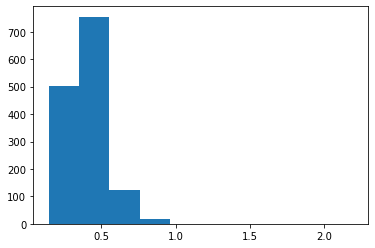

In [13]:
plt.hist(X_train_processed['duration'])

(array([274., 278.,  40.,   6.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.15741496598639457, 0.3699501133786848, 0.5824852607709751,
        0.7950204081632652, 1.0075555555555555, 1.2200907029478458,
        1.432625850340136, 1.6451609977324262, 1.8576961451247165,
        2.0702312925170068, 2.282766439909297], dtype=object),
 <BarContainer object of 10 artists>)

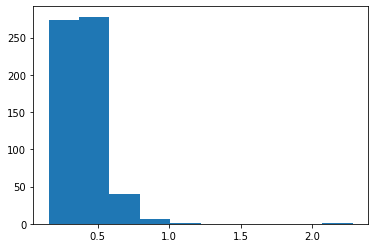

In [14]:
plt.hist(X_test_processed['duration'])

In [15]:
for i in range(0,110,10):
    print(i,'th Percentile is ', np.percentile(X_train_processed['duration'],i))

0 th Percentile is  0.1435374149659864
10 th Percentile is  0.2608934240362812
20 th Percentile is  0.3000634920634921
30 th Percentile is  0.33322902494331064
40 th Percentile is  0.359718820861678
50 th Percentile is  0.3915873015873016
60 th Percentile is  0.418249433106576
70 th Percentile is  0.446625850340136
80 th Percentile is  0.4838639455782313
90 th Percentile is  0.555297052154195
100 th Percentile is  2.195918367346939


In [16]:
for i in range(90,101,1):
    print(i,'th Percentile is ', np.percentile(X_train_processed['duration'],i))

90 th Percentile is  0.555297052154195
91 th Percentile is  0.5679238095238096
92 th Percentile is  0.5812916099773243
93 th Percentile is  0.5978285714285715
94 th Percentile is  0.6133696145124716
95 th Percentile is  0.6253424036281179
96 th Percentile is  0.6424290249433107
97 th Percentile is  0.6647768707482993
98 th Percentile is  0.6957514739229022
99 th Percentile is  0.7906811791383219
100 th Percentile is  2.195918367346939


<font size=4>Grader function 4 </font>

In [17]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [18]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.


def fun(X_train_pad_seq,X_train_processed,X_train_mask):
    for ind,val in enumerate(tqdm(X_train_processed.index)):
        q = X_train_processed['raw_data'][val]
        if q.shape[0] < max_length:
            #q = np.array(X_train_processed['raw_data'][val])
            X_train_pad_seq[ind] = np.pad(q,(0,(max_length-q.shape[0])),'constant')
            X_train_mask[ind][:q.shape[0]] = 1
        elif q.shape[0] >= max_length:
            #print(ind,val)
            #q = np.array(X_train_processed['raw_data'][val])
            X_train_pad_seq[ind] = q[:max_length]
            X_train_mask[ind][:q.shape[0]] = 1
    return X_train_pad_seq,X_train_mask
        
max_length  = 17640
X_train_pad_seq = np.zeros(shape=(X_train_processed.shape[0],max_length))
X_train_mask = np.zeros(shape=(X_train_processed.shape[0],max_length),dtype='bool')
X_train_pad_seq1,X_train_mask1 = fun(X_train_pad_seq,X_train_processed,X_train_mask)

X_test_pad_seq = np.zeros(shape=(X_test_processed.shape[0],max_length))
X_test_mask = np.zeros(shape=(X_test_processed.shape[0],max_length),dtype='bool')
X_test_pad_seq1,X_test_mask1 = fun(X_test_pad_seq,X_test_processed,X_test_mask)


  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

<font size=4>Grader function 5 </font>

In [19]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 


Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). Also check the datatype of class labels(y_values) and make sure that you convert your class labels  to integer datatype before fitting in the model.
3. While defining your model make sure that you pass both the input layer and mask input layer as input to lstm layer as follows
<img src='https://i.imgur.com/FvcgvbY.jpg'>
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 

5. make sure that it won't overfit. 
6. You are free to include any regularization


In [20]:
## as discussed above, please write the architecture of the model.
## you will have two input layers in your model (data input layer and mask input layer)
## make sure that you have defined the data type of masking layer as bool


X_train_pad_seq1 = np.expand_dims(X_train_pad_seq1,-1)
X_test_pad_seq1 = np.expand_dims(X_test_pad_seq1,-1)

y_train1 = y_train.values.astype('int')
y_test1 = y_test.values.astype('int')




In [21]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self,validation_data):
        super().__init__()
        self.x_test=validation_data[0]
        self.y_test=validation_data[1]
        
    def on_epoch_end(self,epoch,logs={}):
        val_predict = np.asarray(self.model.predict(self.x_test))
        val_label = np.argmax(val_predict,axis=1)
        val_target = self.y_test
        val_f1 = f1_score(val_target,val_label,average='micro')
        print("val_f1_score", val_f1)
        

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# pip install tensorflow-addons

In [24]:
#train your model
#model1.fit([X_train_pad_seq,X_train_mask],y_train_int,.........)

def train_model(max_length,):
    #model = create_model()
    data_input_layer = Input(shape = (max_length,1))
    mask_input_layer = Input(shape = (max_length),dtype='bool')
    x = LSTM(25)(inputs = data_input_layer,mask = mask_input_layer)
    x = Dense(50,activation='relu',kernel_initializer = 'he_normal')(x)
    output = Dense(10,activation='softmax',kernel_initializer = 'glorot_normal')(x)
    model = Model(inputs = [data_input_layer, mask_input_layer], outputs = output)

    model.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy') 
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1)

    model.fit(x=[X_train_pad_seq1,X_train_mask1], 
            y=y_train1, 
            epochs=2,batch_size = 32,
            callbacks=[tensorboard_callback,es,Metrics(validation_data=([X_test_pad_seq1,X_test_mask1], y_test1))])

train_model(max_length=max_length)

Epoch 1/2
44/44 [==============================] - ETA: 0s - loss: 2.3036 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.10000000000000002
44/44 [==============================] - 572s 13s/step - loss: 2.3036
Epoch 2/2
44/44 [==============================] - ETA: 0s - loss: 2.3030 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.10000000000000002
44/44 [==============================] - 576s 13s/step - loss: 2.3030


In [56]:
%tensorboard --logdir /Users/srujan/Downloads/spoken_digit/logs/20220809-013151/train

### 2. Converting into spectrogram and giving spectrogram data as input  

We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram


In [25]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [26]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = convert_to_spectrogram(X_train_pad_seq.reshape(1400,17640))
X_test_spectrogram  = convert_to_spectrogram(X_test_pad_seq.reshape(600,17640))

<font size=4>Grader function 6 </font>

In [27]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True


Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (None, time_steps, features) average the output of every time step i.e, you should get (None,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 
5. make sure that it won't overfit. 
6. You are free to include any regularization


In [28]:
# write the architecture of the model
#print model.summary and make sure that it is following point 2 mentioned above
tf.keras.backend.clear_session()
inp = Input(shape = (64,35,))
x = LSTM(256, return_sequences = True)(inp)
x = tf.math.reduce_mean(x, axis = -1)
x = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model2 = Model(inputs = inp, outputs = out)
#printing the model summary
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 256)           299008    
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 318,218
Trainable params: 318,218
Non-trainable params: 0
_______________________________________________________

In [31]:
#compile and fit your model.
#model2.fit([X_train_spectrogram],y_train_int,......)
model2.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',) 
logdir = os.path.join("logs/model2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1)

model2.fit(x=X_train_spectrogram, 
            y=y_train1, 
            epochs=20, 
            batch_size = 32,
            callbacks=[tensorboard_callback,es,Metrics(validation_data=([X_test_spectrogram], y_test1))])

Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 1.9556WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.4000000000000001
44/44 [==============================] - 11s 202ms/step - loss: 1.9556
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 1.5995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.5166666666666667
44/44 [==============================] - 8s 188ms/step - loss: 1.5995
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 1.3520WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.5866666666666667
44/44 [==============================] - 9s 199ms/step - loss: 1.3520
Epoch 4/20
44/44 [==============================] - ETA: 0s - loss: 1.2011WARNING:tensorflow:Early stopping condit

In [55]:
%tensorboard --logdir /Users/srujan/Downloads/spoken_digit/logs/model2/20220809-020409/train

In [ ]:
pip install tensorflow-addons

### 3. Data augmentation with raw features 

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.


In [32]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [33]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [34]:
len(aug_temp)

9

## Follow the steps 

1. Split data 'df_audio' into train and test (80-20 split)

2. We have 2000 data points(1600 train points, 400 test points) 



In [35]:
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3=train_test_split(df_audio['path'],df_audio['label'],random_state=45,test_size=0.2,stratify=df_audio['label'])



3. Do augmentation only on X_train,pass each point of X_train to generate_augmented_data function.After augmentation we will get 14400 train points. Make sure that you are augmenting the corresponding class labels (y_train) also.
4. Preprocess your X_test using load_wav function.
5. Convert the augmented_train_data and test_data to numpy arrays.
6. Perform padding and masking on augmented_train_data and test_data.
7. After padding define the model similar to model 1 and fit the data

<font color='red'> Note </font> - While fitting your model on the augmented data for model 3 you might face Resource exhaust error. One simple hack to avoid that is save the augmented_train_data,augment_y_train,test_data and y_test to Drive or into your local system. Then restart the runtime so that now you can train your model with full RAM capacity. Upload these files again in the new runtime session perform padding and masking and then fit your model.

In [36]:
X_train_aug3 = []
y_train_aug3 = []

#X_train_aug.append(generate_augmented_data(X_train[839]))
for i in tqdm(X_train3.index):
    X_train_aug3.append(generate_augmented_data(X_train3[i]))
    y_train_aug3.append([y_train3[i]]*9)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [37]:
augmented_train_data3 = (np.concatenate(X_train_aug3).ravel())

In [38]:
augmented_label_data3 = (np.concatenate(y_train_aug3).ravel())

In [39]:
X_test_processed3 = pd.DataFrame(columns=['raw_data','duration'],index=X_test3.index)
for i in tqdm(X_test3.index):
    res = load_wav(X_test3[i])
    X_test_processed3['raw_data'][i] = res[0]
    X_test_processed3['duration'][i] = res[1]

  0%|          | 0/400 [00:00<?, ?it/s]

In [40]:
augmented_test_data3 = np.array(X_test_processed3.raw_data)

In [41]:
def fun(X_train_pad_seq,X_train_processed,X_train_mask):
    for ind,val in enumerate(tqdm(X_train_processed)):
        q = val#X_train_processed['raw_data'][val]
        if q.shape[0] < max_length:
            #q = np.array(X_train_processed['raw_data'][val])
            X_train_pad_seq[ind] = np.pad(q,(0,(max_length-q.shape[0])),'constant')
            X_train_mask[ind][:q.shape[0]] = 1
        elif q.shape[0] >= max_length:
            #print(ind,val)
            #q = np.array(X_train_processed['raw_data'][val])
            X_train_pad_seq[ind] = q[:max_length]
            X_train_mask[ind][:q.shape[0]] = 1
    return X_train_pad_seq,X_train_mask
        
max_length = 17640
aug_X_train_pad_seq3 = np.zeros(shape=(augmented_train_data3.shape[0],max_length))
aug_X_train_mask3 = np.zeros(shape=(augmented_train_data3.shape[0],max_length),dtype='bool')
aug_X_train_pad_seq3,aug_X_train_mask3 = fun(aug_X_train_pad_seq3,augmented_train_data3,aug_X_train_mask3)


aug_X_test_pad_seq3 = np.zeros(shape=(augmented_test_data3.shape[0],max_length))
aug_X_test_mask3 = np.zeros(shape=(augmented_test_data3.shape[0],max_length),dtype='bool')
aug_X_test_pad_seq3,aug_X_test_mask3 = fun(aug_X_test_pad_seq3,augmented_test_data3,aug_X_test_mask3)


  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [42]:

X_train_pad_seq3 = np.expand_dims(aug_X_train_pad_seq3,-1)
X_test_pad_seq3 = np.expand_dims(aug_X_test_pad_seq3,-1)

y_train3 = augmented_label_data3.astype('int')
y_test3 = y_test3.values.astype('int')
        
def train_model(max_length,):
    #model = create_model()
    data_input_layer = Input(shape = (max_length,1))
    mask_input_layer = Input(shape = (max_length),dtype='bool')
    x = LSTM(25)(inputs = data_input_layer,mask = mask_input_layer)
    x = Dense(50,activation='relu',kernel_initializer = 'he_normal')(x)
    output = Dense(10,activation='softmax',kernel_initializer = 'glorot_normal')(x)
    model3 = Model(inputs = [data_input_layer, mask_input_layer], outputs = output)

    model3.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy') 
    logdir = os.path.join("logs/Model3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1)

    model3.fit(x=[aug_X_train_pad_seq3,aug_X_train_mask3], 
            y=y_train3, 
            epochs=5,batch_size = 128,
            callbacks=[tensorboard_callback,es,Metrics(validation_data=([aug_X_test_pad_seq3,aug_X_test_mask3], y_test3))])

train_model(max_length=max_length)

Epoch 1/5
113/113 [==============================] - ETA: 0s - loss: 2.3029 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.095
113/113 [==============================] - 3935s 34s/step - loss: 2.3029
Epoch 2/5
113/113 [==============================] - ETA: 0s - loss: 2.3028 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.10000000000000002
113/113 [==============================] - 3984s 35s/step - loss: 2.3028
Epoch 3/5
113/113 [==============================] - ETA: 0s - loss: 2.3028 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.10000000000000002
113/113 [==============================] - 3905s 35s/step - loss: 2.3028
Epoch 4/5
113/113 [==============================] - ETA: 0s - loss: 2.3027 WARNING:tensorflow:Early stopping c

In [54]:
%tensorboard --logdir /Users/srujan/Downloads/spoken_digit/logs/Model3/20220809-021838/train

### 4. Data augmentation with spectogram data

1. use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data

In [43]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [44]:
aug_X_train_spectrogram4 = []
aug_X_test_spectrogram4 = []

In [46]:
for i in tqdm(aug_X_train_pad_seq3):
    aug_X_train_spectrogram4.append(convert_to_spectrogram(i))

  0%|          | 0/14400 [00:00<?, ?it/s]

In [47]:
for i in tqdm(aug_X_test_pad_seq3):
    aug_X_test_spectrogram4.append(convert_to_spectrogram(i))

  0%|          | 0/400 [00:00<?, ?it/s]

In [48]:
tf.keras.backend.clear_session()
inp = Input(shape = (64,35,))
x = LSTM(256, return_sequences = True)(inp)
x = tf.math.reduce_mean(x, axis = -1)
x = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model4 = Model(inputs = inp, outputs = out)
#printing the model summary
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 256)           299008    
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 318,218
Trainable params: 318,218
Non-trainable params: 0
_______________________________________________________

In [49]:
aug_4_X_train_spectrogram = np.expand_dims(aug_X_train_spectrogram4,-1)
aug_4_X_test_spectrogram = np.expand_dims(aug_X_test_spectrogram4,-1)


In [52]:
%load_ext tensorboard
model4.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',) 
logdir = os.path.join("logs/model4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1)

model4.fit(x=aug_4_X_train_spectrogram, 
            y=augmented_label_data3, 
            epochs=20, 
            batch_size = 32,
            callbacks=[tensorboard_callback,es,Metrics(validation_data=([aug_4_X_test_spectrogram], y_test3))])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
450/450 [==============================] - ETA: 0s - loss: 0.5259WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.895
450/450 [==============================] - 86s 186ms/step - loss: 0.5259
Epoch 2/20
450/450 [==============================] - ETA: 0s - loss: 0.4301WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.9125
450/450 [==============================] - 77s 171ms/step - loss: 0.4301
Epoch 3/20
450/450 [==============================] - ETA: 0s - loss: 0.3879WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
val_f1_score 0.935
450/450 [==============================] - 70s 155ms/step - loss: 0.3879
Epoch 4/20
450/450 [============================

In [53]:
%tensorboard --logdir /Users/srujan/Downloads/spoken_digit/logs/model4/20220809-130905/train